# Filtering lithology by formation

In this recipe, we'll show how you can filter lithology information to a specific formation. Specifically, we'll show how you can find all the lithologies with `mudstone` confined to the Horton Group.

In [1]:
from striplog import Striplog, Lexicon, Legend
% matplotlib inline

## Stratigraphic data

Read a simple csv of tops into a list.

In [2]:
topsfile = 'data/tops/P-129_tops.csv'

In [3]:
import csv

def get_tops(fname, wellid):
    """
    Get all the tops corrsponding to the first column name of well
    """
    tops = ''
    with open(fname, 'r') as f:
        for line in f.readlines():
            row = line.strip().split(',')
            if row[0] == wellid:
                name = row[1]
                md = row[5]
                tops += md + ', ' + str(name) +  '\n '
    return tops

In [4]:
topslist = get_tops(topsfile, 'P-129')

In [5]:
l = Lexicon.default()
l.formation = [r'\w+']

In [6]:
formations = Striplog.from_descriptions(topslist, lexicon=l, order='auto')
for frm in formations:
    print(frm.summary(fmt='{formation!t}'), frm.top.middle, '-',frm.base.middle)

107.71 m of Lower Windsor 698.33 - 806.04
140.48 m of Horton 806.04 - 946.52
959.83 m of Horton Bluff 946.52 - 1906.35
32.11 m of Maguma 1906.35 - 1938.46
1.00 m of Td 1938.46 - 1939.46


We need to make a legend for our formations, otherwise we won't be able to see it.

In [7]:
strat_str = """colour,  width, comp formation
        #FFFFFF, 1, none
        #9999ff, 1, lower windsor
        #ffcc00, 1, horton
        #cc6600, 1, horton bluff
        #660033, 1, meguma
"""

In [8]:
tops_legend = Legend.from_csv(strat_str)

## Make a `striplog` from image

In [9]:
imgfile = "data/images/P-129_280_1935.png"

In [10]:
legend = Legend.default(name='nsdoe')

In [11]:
top, base = 280.0, 1935.0
strip = Striplog.from_image(imgfile, top, base, legend=legend)

## Create a `well` object 

In [12]:
from welly import Well, Curve

In [13]:
well = Well.from_las('data/las/P-129_out.LAS')

In [14]:
curve_legend_csv = """colour,lw,xscale,curve mnemonic
#006400,1.0,linear,GR
#000000,1.0,log,RLA5
#000000,1.0,linear,RHOB
#CCFFCC,1.0,linear,NPHI_SAN
blue,1.0,linear,DT
green,1.0,linear,DTS
"""
curve_legend = Legend.from_csv(curve_legend_csv)

Add our `formations` and `lithology` striplogs to the `well` object.

In [15]:
well.data['FM'] = formations
well.data['strip'] = strip

In [16]:
complete_legend = tops_legend + curve_legend + legend

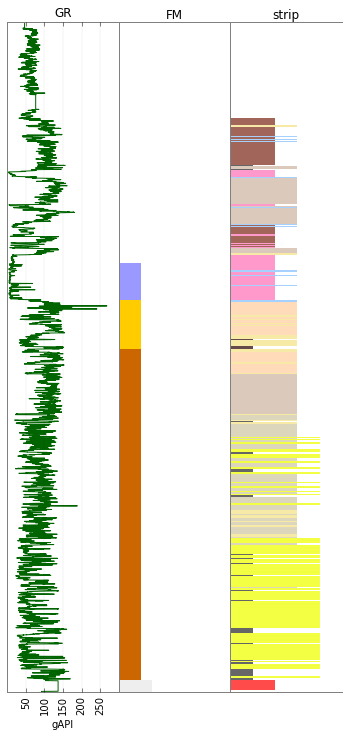

In [17]:
tracks = ['GR','FM','strip']
well.plot(tracks=tracks, legend=complete_legend)

# Apply point data to Formation intervals

In [23]:
muds = well.data['strip'].find('mud') # a striplog with only muds
Hort = well.data['FM'].find('Horton') # a striplog with only 'Horton' in formation name

Perform a `intersect`,

In [24]:
ShalyHort = muds.intersect(Hort)

Add this new striplog to the well, and give it a name: `Horton Shales`

In [25]:
well.data['Horton Shales']=ShalyHort

In [34]:
tracks = ['GR','FM','Horton Shales']
well.plot(tracks=tracks, legend=complete_legend)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10c240510> (for post_execute):


RuntimeError: Locator attempting to generate 1940 ticks from 1.0 to 1940.0: exceeds Locator.MAXTICKS

RuntimeError: Locator attempting to generate 1940 ticks from 1.0 to 1940.0: exceeds Locator.MAXTICKS

Note that when we use the `find()` method on a striplog, the search term can be a regular expression (regex). So if we wanted the mudstones in just the <i>Horton</i> say, and not the <i>Horton Bluff</i>, we could do,

In [29]:
Horton = well.data['FM'].find('^Horton$') # a striplog with only '^horton$' in formation name
ShalyHorton = muds.intersect(Horton)
well.data['Lower Horton Shales'] = ShalyHorton

In [30]:
tracks = ['GR','FM','Lower Horton Shales', 'strip']
well.plot(tracks=tracks, legend=complete_legend)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x10c240510> (for post_execute):


RuntimeError: Locator attempting to generate 1940 ticks from 1.0 to 1940.0: exceeds Locator.MAXTICKS

RuntimeError: Locator attempting to generate 1940 ticks from 1.0 to 1940.0: exceeds Locator.MAXTICKS